In [1]:
import tensorflow as tf
# import tools.image_gen_extended as T
from tensorflow.keras import Input, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Convolution2D, MaxPool2D, GlobalAveragePooling2D 
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os

The history saving thread hit an unexpected error (OperationalError('database or disk is full',)).History will not be written to the database.


/opt/anaconda/envs/i2s/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda/envs/i2s/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda/envs/i2s/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda/envs/i2s/lib/python3.5/site-packages/tensorflow/python/framework/dty

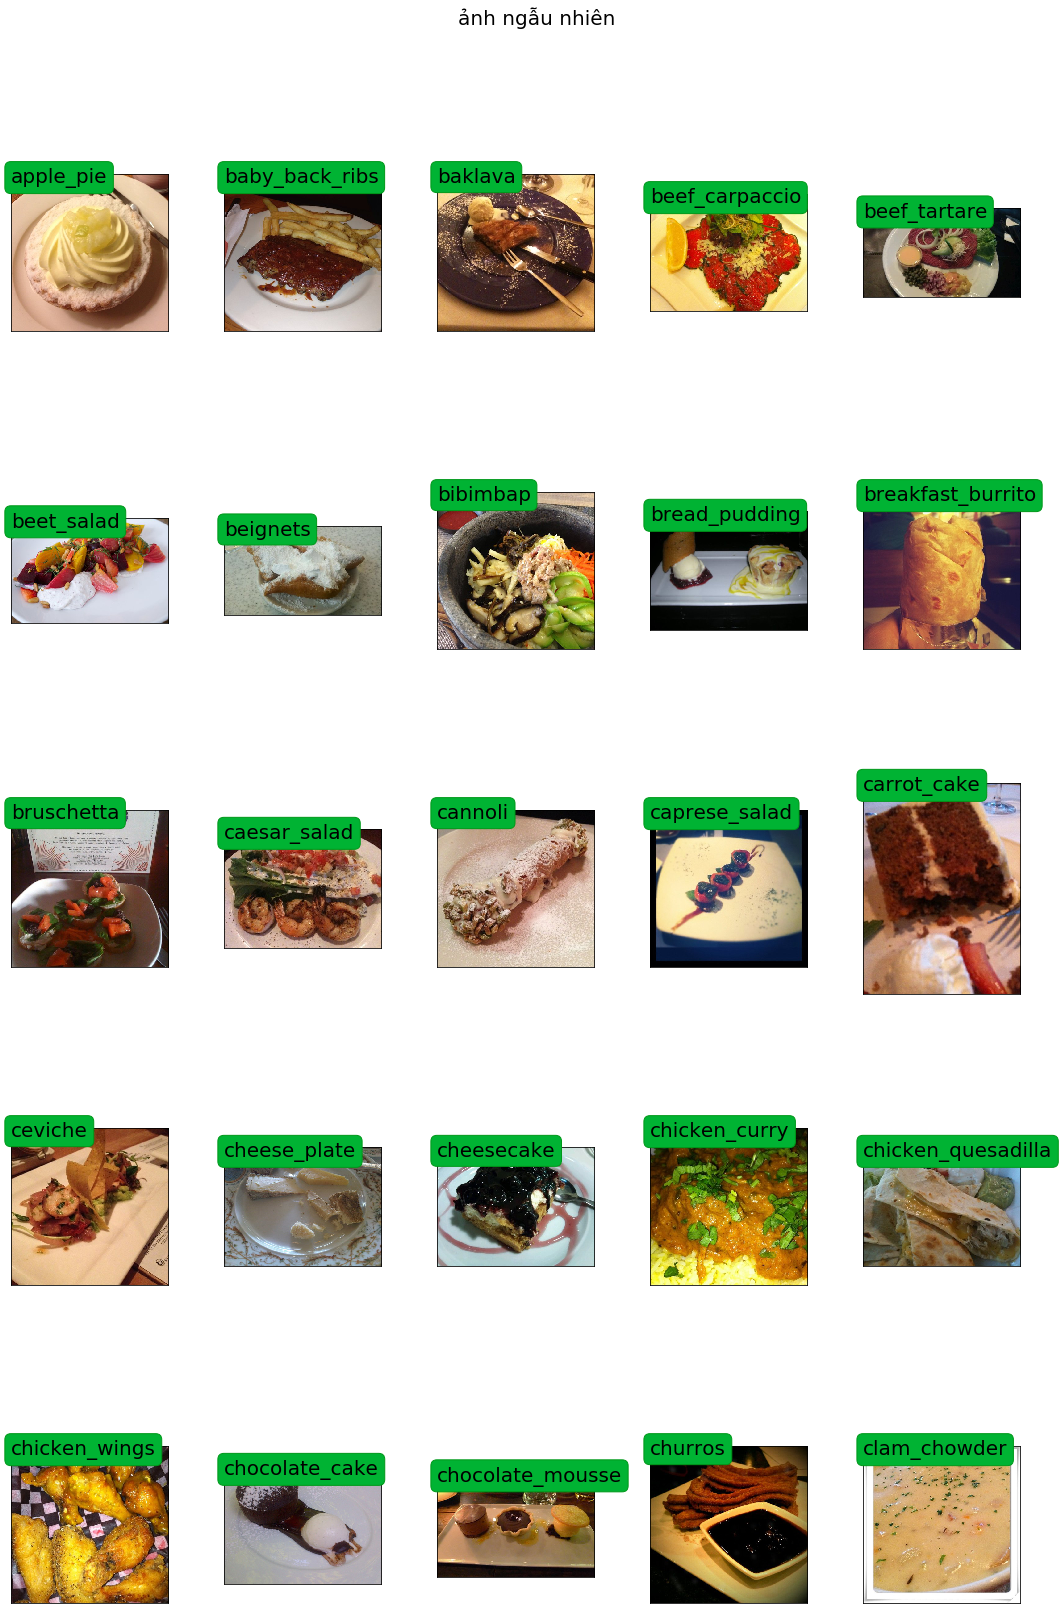

In [2]:
root_dir = 'food-101/images/'
rows = 5
cols = 5
fig, ax = plt.subplots(rows, cols,  figsize=(15, 25))
fig.suptitle('ảnh ngẫu nhiên', fontsize=20)
sorted_food_dirs = sorted(os.listdir(root_dir))
# print(sorted_food_dirs)
for i in range(rows):
    for j in range(cols):
        food_dir = sorted_food_dirs[i*cols + j]
        all_files = os.listdir(os.path.join(root_dir, food_dir))
        rand_img = np.random.choice(all_files)
        img = plt.imread(os.path.join(root_dir, food_dir, rand_img))
        ax[i][j].imshow(img)
        ec = (0, .6, .1)
        fc = (0, .7, .2)
        ax[i][j].text(0, -20, food_dir, size=20, rotation=0,
                ha="left", va="top", 
                bbox=dict(boxstyle="round", ec=ec, fc=fc))
plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [3]:
BATCH_SIZE = 32
INPUT_SIZE = (299, 299)
EPOCH = 30
n_classes = 101
TRAIN_PATH = 'train/'
TEST_PATH = 'test/'
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

train_datagen = ImageDataGenerator(rescale=1./255,
#                                    featurewise_center=False,  # set input mean to 0 over the dataset
#                                    samplewise_center=False,  # set each sample mean to 0
#                                    featurewise_std_normalization=False,  # divide inputs by std of the dataset
#                                    samplewise_std_normalization=False,  # divide each input by its std
                                   zoom_range=[.8, 1],
#                                    zca_whitening=True,
                                   shear_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   channel_shift_range=30,
                                   fill_mode='reflect',
                                   validation_split=0.2
                                  )



train_generator = train_datagen.flow_from_directory(TRAIN_PATH,
                                                    target_size=INPUT_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    subset='training'
                                                   )

val_generator = train_datagen.flow_from_directory(TRAIN_PATH,
                                                  target_size=INPUT_SIZE,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical',
                                                  subset='validation'
                                                   )



Found 60600 images belonging to 101 classes.
Found 15150 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.


In [4]:
inception_model = InceptionV3(weights='imagenet', 
                              include_top=False, 
                              input_tensor=Input(shape=(INPUT_SIZE[0], INPUT_SIZE[1], 3))
                             )

In [5]:
inception_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (

In [ ]:
out = inception_model.output
out = GlobalAveragePooling2D()(out)
out = Dropout(0.2)(out)
out = Dense(n_classes, kernel_regularizer=regularizers.l2(.0005), activation='softmax')(out)

model = Model(inputs=inception_model.input, outputs=out)

SGD_Optimizer = SGD(lr=.01, momentum=.9)
model.compile(optimizer=SGD_Optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (

In [ ]:
checkpoint = ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.hdf5', save_best_only=True)
csv_logger = CSVLogger('train.log')
history = model.fit_generator(train_generator,
                              steps_per_epoch = train_generator.samples // BATCH_SIZE,
                              validation_data = val_generator,
                              validation_steps = val_generator.samples // BATCH_SIZE,
                              epochs=EPOCH,
#                               verbose=1,
                              callbacks=[checkpoint, csv_logger])

Epoch 1/30
1893/1893 [==============================] - 1913s 1s/step - loss: 2.2861 - acc: 0.4651 - val_loss: 2.7973 - val_acc: 0.3631
Epoch 2/30
1893/1893 [==============================] - 1325s 700ms/step - loss: 1.5499 - acc: 0.6268 - val_loss: 2.0531 - val_acc: 0.5303
Epoch 3/30
1893/1893 [==============================] - 1331s 703ms/step - loss: 1.3027 - acc: 0.6863 - val_loss: 1.9838 - val_acc: 0.5514
Epoch 4/30
1893/1893 [==============================] - 1321s 698ms/step - loss: 1.1359 - acc: 0.7273 - val_loss: 1.7656 - val_acc: 0.5905
Epoch 5/30
1893/1893 [==============================] - 1354s 715ms/step - loss: 1.0096 - acc: 0.7591 - val_loss: 1.6493 - val_acc: 0.6292
Epoch 6/30
1893/1893 [==============================] - 1325s 700ms/step - loss: 0.9228 - acc: 0.7802 - val_loss: 1.5612 - val_acc: 0.6458
Epoch 7/30
1893/1893 [==============================] - 1338s 707ms/step - loss: 0.8263 - acc: 0.8035 - val_loss: 1.3532 - val_acc: 0.6921
Epoch 8/30
1893/1893 [========

In [ ]:
os._exit(00)